Most of contents in this notebook is adapted from section 13.6 in ISLR v2, except the R code is translated into Python code.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## 13.6.1

In [2]:
np.random.seed(12)

In [3]:
x = np.random.normal(loc=0, scale=1, size=(10, 100))
x[:, 1:50] = x[:, 1:50] + 0.5

In [4]:
stats.ttest_1samp(x[:, 0], popmean=0)

Ttest_1sampResult(statistic=-1.1808272665876596, pvalue=0.2679357933386311)

In [5]:
def get_p_value(arr):
    return stats.ttest_1samp(arr, popmean=0).pvalue

In [6]:
def get_summary_result(p_value_l, alpha=0.05):
    df_summary = pd.DataFrame({
        'p_value': p_value_l,
        'truth': ['H0 is False'] * 50 + ['H0 is True'] * 50
    })
    df_summary['decision'] = np.where(df_summary.p_value < 0.05, 'Reject H0', 'Do not Reject H0')
    return df_summary[['truth', 'decision']].value_counts().unstack().T


In [7]:
p_value_l = np.array([get_p_value(x[:, i]) for i in range(100)])
get_summary_result(p_value_l)

truth,H0 is False,H0 is True
decision,,
Do not Reject H0,36,48
Reject H0,14,2


In [8]:
x1 = np.random.normal(loc=0, scale=1, size=(10, 100))
x1[:, 1:50] = x1[:, 1:50] + 1
p_value_l = np.array([get_p_value(x1[:, i]) for i in range(100)])
get_summary_result(p_value_l)

truth,H0 is False,H0 is True
decision,,
Do not Reject H0,10,48
Reject H0,40,2


## 13.6.2 The Family-Wise Error Rate

In [9]:
m = np.arange(1, 501, step=1)
len(m)

500

In [10]:
fwe1 = 1 - (1 - 0.05) ** m
fwe2 = 1 - (1 - 0.01) ** m
fwe3 = 1 - (1 - 0.001) ** m

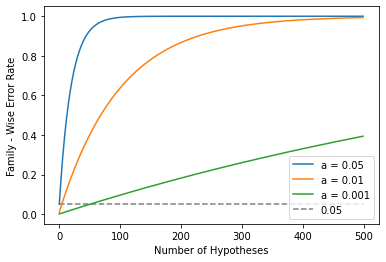

In [11]:
for error_arr, alpha in zip([fwe1, fwe2, fwe3], ['0.05', '0.01', '0.001']):
    plt.plot(error_arr, label=f'a = {alpha}')
plt.hlines(y=0.05,
           xmin=0,
           xmax=500,
           linestyles='--',
           color='gray',
           label='0.05')
plt.legend()
plt.xlabel('Number of Hypotheses')
plt.ylabel('Family - Wise Error Rate')
plt.show()

In [12]:
df_fund = pd.read_csv('../data/fund.csv')
df_fund_mini = df_fund.iloc[:, 0:5]

In [13]:
stats.ttest_1samp(df_fund_mini.iloc[:, 0].values, popmean=0)

Ttest_1sampResult(statistic=2.8603877677367766, pvalue=0.00620235548553822)

In [14]:
p_value_l = []
for i in range(5):
    test_result = stats.ttest_1samp(df_fund_mini.iloc[:, i].values, popmean=0)
    p_value_l.append(test_result.pvalue)

In [15]:
p_value_l

[0.00620235548553822,
 0.918271151651412,
 0.011600982682500436,
 0.6005396008061638,
 0.7557815084668175]

In [16]:
_, p_vals_corrected_bon, _, _ = multipletests(p_value_l, method='bonferroni')
p_vals_corrected_bon

array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ])

In [17]:
_, p_vals_corrected_holm, _, _ = multipletests(p_value_l, method='holm')
p_vals_corrected_holm

array([0.03101178, 1.        , 0.04640393, 1.        , 1.        ])

In [18]:
df_fund_mini.mean(axis=0)

Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64

Note that for paired t-test, we use the [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) function.

In [19]:
stats.ttest_rel(df_fund_mini.iloc[:, 0].values, df_fund_mini.iloc[:, 1].values)

Ttest_relResult(statistic=2.128014948148984, pvalue=0.038391072368079454)

In [20]:
df_fund_mini_long = df_fund_mini.melt()

In [21]:
df_fund_mini_long.head(3)

,variable,value
0,Manager1,-3.341992
1,Manager1,3.759627
2,Manager1,12.970091


In [22]:
m_comp_th = pairwise_tukeyhsd(endog=df_fund_mini_long['value'], groups=df_fund_mini_long['variable'])

In [23]:
df_fund_mini.columns

Index(['Manager1', 'Manager2', 'Manager3', 'Manager4', 'Manager5'], dtype='object')

In [24]:
# Inspired by: https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe
df_summary = pd.read_html(m_comp_th.summary().as_html())[0]

In [25]:
df_summary

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Manager1,Manager2,-3.1,0.1861,-6.9866,0.7866,False
1,Manager1,Manager3,-0.2,0.9000,-4.0866,3.6866,False
2,Manager1,Manager4,-2.5,0.3962,-6.3866,1.3866,False
3,Manager1,Manager5,-2.7,0.3152,-6.5866,1.1866,False
4,Manager2,Manager3,2.9,0.2452,-0.9866,6.7866,False
5,Manager2,Manager4,0.6,0.9000,-3.2866,4.4866,False
6,Manager2,Manager5,0.4,0.9000,-3.4866,4.2866,False
7,Manager3,Manager4,-2.3,0.4825,-6.1866,1.5866,False
8,Manager3,Manager5,-2.5,0.3962,-6.3866,1.3866,False
9,Manager4,Manager5,-0.2,0.9000,-4.0866,3.6866,False


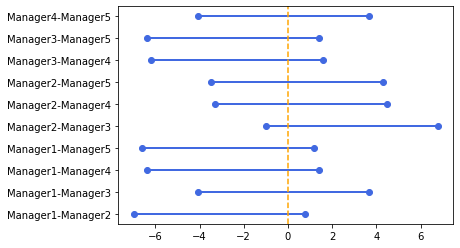

In [26]:
# Inspired by: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
for lower, upper, y in zip(df_summary['lower'].values,
                           df_summary['upper'].values, range(len(df_summary))):
    plt.plot((lower, upper), (y, y), 'ro-', color='royalblue', linewidth=2)
plt.yticks(range(len(df_summary)),
           list(df_summary['group1'] + '-' + df_summary['group2']))
plt.axvline(x=0, linestyle='--', color='orange')
plt.show()
